# EJERCICIO

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
import joblib
import warnings
import math

In [108]:
warnings.filterwarnings("ignore", category=FutureWarning)
set_config(display="diagram")

## DEFINICIÓN DEL PROBLEMA

**Vamos a trabajar con un dataframe sobre los datos del titanic que viene en la librería seaborn para intentar predecir si una persona sobrevivió o no a partir del resto de atributos.**

**Como criterio de evaluación vamos a usar la exactitud (accuracy), que mide la proporción de predicciones correctas realizadas por el modelo.**

## RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

### OBTENER LOS DATOS

In [109]:
df_titanic = sns.load_dataset('titanic')


En el conjunto de datos Titanic, cada columna proporciona información específica sobre los pasajeros del Titanic.

1. `survived`: Esta columna indica si un pasajero sobrevivió o no al naufragio del Titanic. Tiene dos valores posibles: 0 (no sobrevivió) y 1 (sobrevivió).

2. `pclass`: Representa la clase de pasaje del pasajero en el Titanic. Tiene tres valores posibles: 1 (primera clase), 2 (segunda clase) y 3 (tercera clase).

3. `sex`: Indica el género del pasajero, ya sea masculino o femenino.

4. `age`: Representa la edad del pasajero en años.

5. `sibsp`: Indica el número de hermanos o cónyuges que el pasajero tenía a bordo del Titanic.

6. `parch`: Representa el número de padres o hijos que el pasajero tenía a bordo del Titanic.

7. `fare`: Indica la tarifa que el pasajero pagó por su pasaje.

8. `embarked`: Representa el puerto de embarque del pasajero. Tiene tres valores posibles: "C" (Cherbourg), "Q" (Queenstown) y "S" (Southampton).

9. `class`: Similar a `pclass`, pero se expresa en palabras en lugar de números.

10. `who`: Indica si el pasajero es un niño (child), hombre (man) o mujer (woman).

11. `adult_male`: Indica si el pasajero es adulto y masculino.

12. `deck`: Representa la cubierta en la que se encontraba la cabina del pasajero (si es que se encontraba en cubierta).

13. `embark_town`: El nombre de la ciudad o localidad correspondiente al puerto de embarque.

14. `alive`: Indica si el pasajero está vivo o muerto. Similar a `survived`, pero se expresa como "yes" (sí) o "no" (no).

15. `alone`: Indica si el pasajero viajaba solo (True) o con compañía (False).

### EXPLORAR LOS DATOS

Muestra las primeras líneas del dataframe

In [110]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


¿Cuántas columnas hay? ¿De que tipo? ¿Cuántos valores no nulos tiene cada columna?

In [111]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Elimina las columnas innecesarias:
- `class`: la información está también en pclass
- `who`: con sex y age se obtiene la información
- `adult_male`: con sex y age se obiene la información
- `deck`: tiene muchos valores nulos y es díficil decidir que valor dar a los valores ausentes
- `embark_town`: la información está también en embarked
- `alive`: la información está también en survived
- `alone`: con sibsp y parch se obtiene la información

In [112]:
a_borrar=["class","who","adult_male","deck","embark_town","alive","alone"]
df_titanic_limpio=df_titanic.drop(a_borrar,axis=1)

df_titanic_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Muestra las estadísticas básicas de los atributos numéricos

In [113]:
df_titanic_limpio.describe()


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Muestra las estadísticas descriptivas de los atributos categóricos (con el parametro include)

In [114]:
df_titanic_limpio.describe(include="object")

,sex,embarked
count,891,889
unique,2,3
top,male,S
freq,577,644


Respresenta los atributos en un histograma o diagrama de barras para ver sus distribuciones: 
- usa seaborn
- dibuja los ochos en un mismo grafico con 8 subgrafos (4x2)
- usa counplot de seaborn para las variables categoricas o discretas
- usa histplot de seaborn para las variables continuas

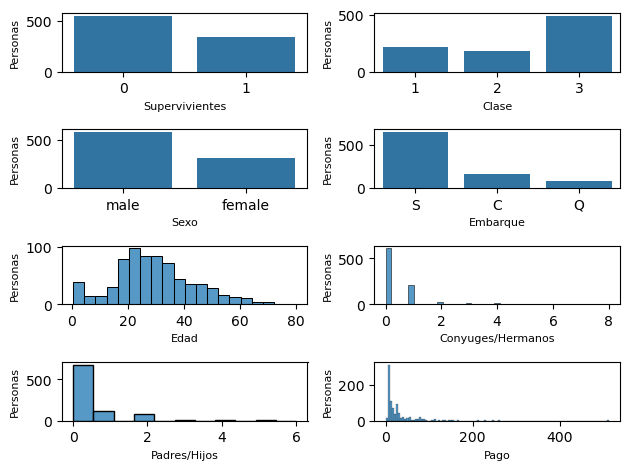

In [115]:
Xs=['survived','pclass','sex','embarked','age','sibsp','parch','fare']
xlabels=['Supervivientes','Clase','Sexo','Embarque','Edad','Conyuges/Hermanos','Padres/Hijos','Pago']
for x in range(8):
    plt.subplot(4,2,x+1)
    plt.ylabel("Personas",fontsize=8)
    plt.xlabel(xlabels[x],fontsize=8)
    if x<4:
        sns.countplot(df_titanic_limpio,x=Xs[x],legend=None)
    else:
        sns.histplot(df_titanic_limpio,x=Xs[x],legend=None)


plt.tight_layout()
plt.show()



¿A la vista de los datos que conclusiones puedes sacar?

In [116]:
"""
Muerieron más de la mitad de los pasajeros.
Aquellos que viajaban en tercera clase tuvieron una mayor tasa de muertos por una difenrecia abismal.
Muerieron la mayoria de los hombres, priorizaron el desembarque de mujeres y niños.
Viendo la distribución de edades tampoco habia mucho niño que salvar. 
La mayoria de edades se comprendian entre los 20 y los 45 (estimación hecha un poco a ojo) y murieron algo más de la mitad.
La mayoria de gente pago aparentemente poco y de esos murieron casi todos.
Los que embarcaron por la puerta sur murieron mucho más, seguramente era la puerta de embarque de la tercera clase.
"""

'\nMuerieron más de la mitad de los pasajeros.\nAquellos que viajaban en tercera clase tuvieron una mayor tasa de muertos por una difenrecia abismal.\nMuerieron la mayoria de los hombres, priorizaron el desembarque de mujeres y niños.\nViendo la distribución de edades tampoco habia mucho niño que salvar. \nLa mayoria de edades se comprendian entre los 20 y los 45 (estimación hecha un poco a ojo) y murieron algo más de la mitad.\nLa mayoria de gente pago aparentemente poco y de esos murieron casi todos.\nLos que embarcaron por la puerta sur murieron mucho más, seguramente era la puerta de embarque de la tercera clase.\n'

Muestra la media de supervivientes según el la clase de billete ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [117]:
media_pclass=df_titanic_limpio[['pclass','survived']].groupby('pclass').mean()
media_pclass=media_pclass.sort_values(by='survived',ascending=False)
media_pclass

,survived
pclass,
1,0.629630
2,0.472826
3,0.242363


In [118]:
"""
Las clases más baratas seguramente contarian con habitaciones más bajas a las que el agua llegaria antes,
dificultando los rescates de los viajeros de tercera clase.
"""

'\nLas clases más baratas seguramente contarian con habitaciones más bajas a las que el agua llegaria antes,\ndificultando los rescates de los viajeros de tercera clase.\n'

Muestra la media de supervivientes según el sexo ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [119]:
media_sex=df_titanic_limpio[['sex','survived']].groupby('sex').mean()
media_sex=media_sex.sort_values(by='survived',ascending=False)
media_sex

,survived
sex,
female,0.742038
male,0.188908


In [120]:
"""
Priorizaron a las mujeres y a los niños en el desembarco, funcionó.
""" 

'\nPriorizaron a las mujeres y a los niños en el desembarco, funcionó.\n'

Muestra la media de supervivientes según el número de hermanos y coyúnges ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [121]:
media_hermanos_conyujes=df_titanic_limpio[['sibsp','survived']].groupby('sibsp').mean()
media_hermanos_conyujes=media_hermanos_conyujes.sort_values(by='survived',ascending=False)
media_hermanos_conyujes

,survived
sibsp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [122]:
"""
Aquellos que viajaron con varios hermanos y/o conyujes a bordo sobrevivieron menos, seguramente se deba a 
que al intentar salvar a sus familiares varias personas asumirian riesgos innecesarios, resultando ser fatales.
"""

'\nAquellos que viajaron con varios hermanos y/o conyujes a bordo sobrevivieron menos, seguramente se deba a \nque al intentar salvar a sus familiares varias personas asumirian riesgos innecesarios, resultando ser fatales.\n'

Muestra la media de supervivientes según el número de padres e hijos ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [123]:
media_padres_hijos=df_titanic_limpio[['parch','survived']].groupby('parch').mean()
media_padres_hijos=media_padres_hijos.sort_values(by='survived',ascending=False)
media_padres_hijos

,survived
parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


In [124]:
"""
Aparentemente hubo mayor tasa de supervivencia entre aquellos que llevaban varios padres/hijos a bordo,
esto posiblemente se deba a que muchos padres priorizarian la supervivencia de sus varios hijos sobre la suya propia.
"""

'\nAparentemente hubo mayor tasa de supervivencia entre aquellos que llevaban varios padres/hijos a bordo,\nesto posiblemente se deba a que muchos padres priorizarian la supervivencia de sus varios hijos sobre la suya propia.\n'

Halla las correlaciones de los datos numéricos y muestra el coeficiente de correlacion de las diferentes variables respecto a la variable survived

In [125]:
corr_matrix = df_titanic_limpio.corr(numeric_only=True)
corr_matrix['survived'].sort_values(ascending=False)


survived    1.000000
fare        0.257307
parch       0.081629
sibsp      -0.035322
age        -0.077221
pclass     -0.338481
Name: survived, dtype: float64

Representa la matriz de correlaciones (representa directamente la matriz usando el stilo background_gradient)

In [126]:
corr_matrix.style.background_gradient()

,survived,pclass,age,sibsp,parch,fare
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


¿Qué conclusiones sacas de la matriz de correlaciones?

In [127]:
"""
Las clases numericamente mas bajas (es decir las más caras), tuvieron mayor tasa de supervivencia,
esto seguramente se debe a que sus camarotes estarian más altos y por ende tendrian mayor tiempo para evacuar.
Esto tambien se refleja con la variable 'fare', hubo mayor tasa de superviventes entre aquellos que pagaron más.
Las variables Sibsp y Parch parecen estar bastante relacinadas, parece que viajar junto a toda la familia fue
una opción bastante habitual, curiosamente su relación con la tasa de supervivencia es sorprendentemente baja.
"""

"\nLas clases numericamente mas bajas (es decir las más caras), tuvieron mayor tasa de supervivencia,\nesto seguramente se debe a que sus camarotes estarian más altos y por ende tendrian mayor tiempo para evacuar.\nEsto tambien se refleja con la variable 'fare', hubo mayor tasa de superviventes entre aquellos que pagaron más.\nLas variables Sibsp y Parch parecen estar bastante relacinadas, parece que viajar junto a toda la familia fue\nuna opción bastante habitual, curiosamente su relación con la tasa de supervivencia es sorprendentemente baja.\n"

Vamos a seguir explorando los datos haciendo algún gráfico más:

- Grafico de barras para representar el número de supervivientes según la clase de billete y por sexos

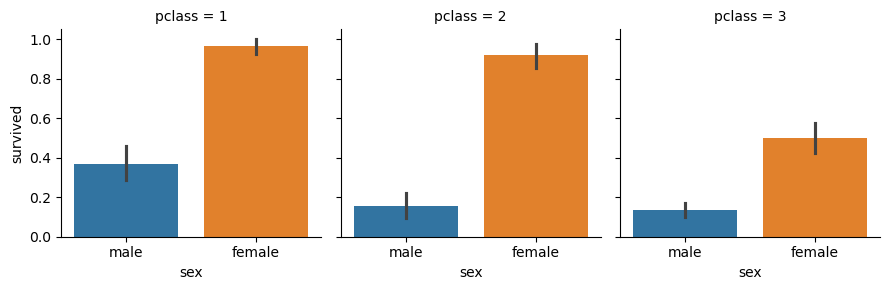

In [128]:

g=sns.FacetGrid(df_titanic_limpio,col='pclass',hue='sex')
g.map(sns.barplot,"sex","survived",order=['male','female'])



- Usando FaceGird de seaborn representa los supervivientes según la clase de billete y el puerto de embarque

/home/iabd/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


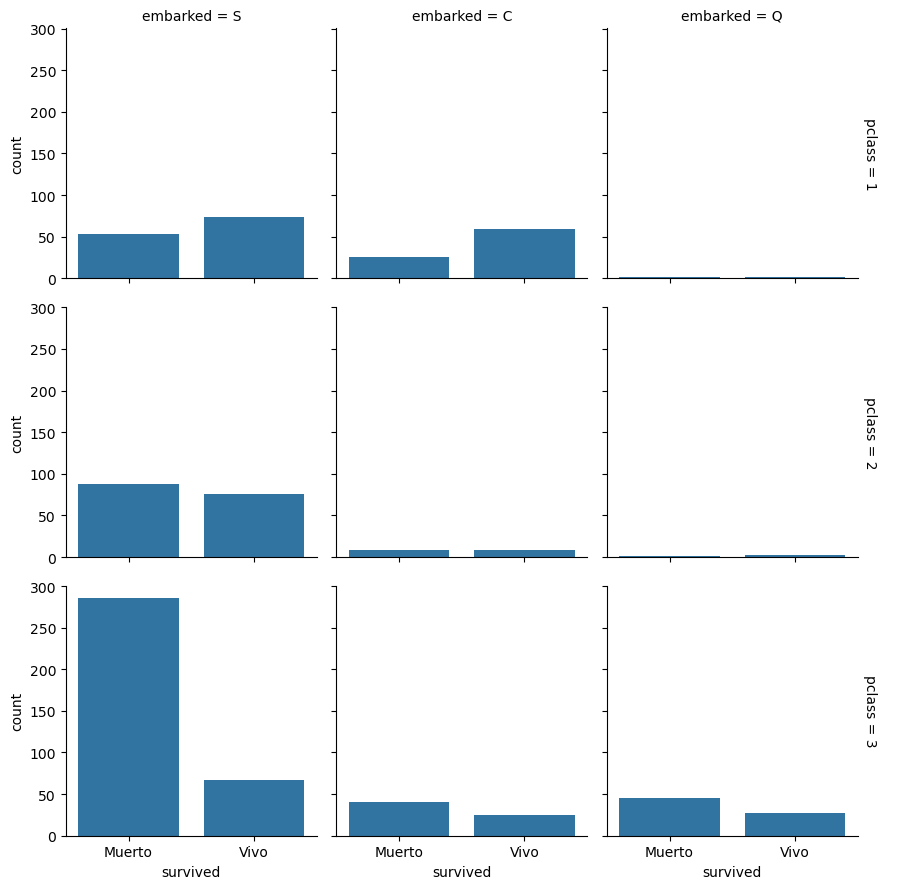

In [129]:
g=sns.FacetGrid(df_titanic_limpio,col='embarked',row='pclass',margin_titles=True)
g.map(sns.countplot,'survived')
g.add_legend()
g.set_xticklabels(["Muerto","Vivo"])

### DIVIDIR LOS DATOS

Es hora de separar el conjunto de entrenamiento del conjunto de prueba (85% para el entrenamiento y haciendo un muestreo estratificado según la clase del billete, que parece que es una de las más correlacionada con la carracteristica survived y hay bastante más pasajeros de clase 3 que de clase 1 y2).

In [130]:
df_titanic_train, df_titanic_test = train_test_split(df_titanic_limpio, test_size=0.15, stratify=df_titanic_limpio['pclass'], random_state=17)


Haz una copia del conjunto de entrenamiento para trabajar con él.

In [131]:
df_titanic_train_copy = df_titanic_train.copy()

### PREPARAR LOS DATOS

Hay que crear un pipeline de transformación que haga los siguientes cambios:
- pclass: 
  - rellenar datos faltantes con la moda
- sex:
  - rellenar datos faltantes con la moda
  - convertir male a 0 y female a 1
- age:
  - rellenar datos faltantes con la media
  - convertirla en variable categórica:
      - 1 - <=16
      - 2 - (16,32]
      - 3 - (32,48]
      - 4 - (48,64]
      - 5 - >64)
- family = sibsp + parch
  - rellenar datos faltantes con la moda
  - sumar las dos columnas
- fare
  - rellenar datos faltantes con la media
  - aplicar raiz cuadrada
  - estandarizar
- embarked
  - rellenar datos faltantes con la moda
  - aplicar one-hot

Pero vamos a empezar poco a poco

Crea el atributo familia como suma de sibsp y parch y luego borra sibsp y parch

In [132]:
df_titanic_train_copy["family"]=df_titanic_train_copy["sibsp"]+df_titanic_train_copy["parch"]
a_borrar=["sibsp","parch"]
df_titanic_train_copy=df_titanic_train_copy.drop(a_borrar,axis=1)

Rellenamos los datos ausentes en el dataframe (lo hacemos para todas las columnas aunque ahora la mayoría no tiene datos ausentes, pero no sabemos como serán los datos si tenemos que volver a entrenar el modelo)

In [133]:
imputer_moda = SimpleImputer(strategy="most_frequent")
imputer_media = SimpleImputer(strategy="mean")

survived=np.reshape(df_titanic_train_copy["survived"], (-1, 1))

columnas_moda = df_titanic_train_copy[["pclass","sex","family","embarked"]]
columnas_media = df_titanic_train_copy[["age","fare"]]
columnas=["survived","pclass","sex","family","embarked","age","fare"]


transf_moda = imputer_moda.fit_transform(columnas_moda)
transf_media = imputer_media.fit_transform(columnas_media)

transf = np.concatenate((survived,transf_moda,transf_media),axis=1)

df_titanic_train_copy = pd.DataFrame(transf, columns=columnas, index=df_titanic_train_copy.index)


df_titanic_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 757 entries, 211 to 640
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   survived  757 non-null    object
 1   pclass    757 non-null    object
 2   sex       757 non-null    object
 3   family    757 non-null    object
 4   embarked  757 non-null    object
 5   age       757 non-null    object
 6   fare      757 non-null    object
dtypes: object(7)
memory usage: 47.3+ KB


En el columna sex sustituir male por 0 y female por 1

In [134]:
df_titanic_train_copy['sex'] = df_titanic_train_copy['sex'].replace({'male':0,'female':1})
df_titanic_train_copy.head()

,survived,pclass,sex,family,embarked,age,fare
211,1,2,1,0,S,35.0,21.0
672,0,2,0,0,S,70.0,10.5
771,0,3,0,0,S,48.0,7.8542
598,0,3,0,0,C,30.121636,7.225
358,1,3,1,0,Q,30.121636,7.8792


Aplicar One-Hot a la columna embarked

In [135]:
df_titanic_train_copy_cats = df_titanic_train_copy[["embarked"]]
cat_encoder=OneHotEncoder()
df_titanic_train_copy_1hot=cat_encoder.fit_transform(df_titanic_train_copy_cats)
df_titanic_train_copy_1hot.toarray()
df_output = pd.DataFrame(cat_encoder.transform(df_titanic_train_copy_cats).toarray(), columns=cat_encoder.get_feature_names_out(), index=df_titanic_train_copy_cats.index)
df_titanic_train_copy = pd.concat([df_titanic_train_copy,df_output],axis=1)
df_titanic_train_copy=df_titanic_train_copy.drop("embarked",axis=1)
df_titanic_train_copy.head()


,survived,pclass,sex,family,age,fare,embarked_C,embarked_Q,embarked_S
211,1,2,1,0,35.0,21.0,0.0,0.0,1.0
672,0,2,0,0,70.0,10.5,0.0,0.0,1.0
771,0,3,0,0,48.0,7.8542,0.0,0.0,1.0
598,0,3,0,0,30.121636,7.225,1.0,0.0,0.0
358,1,3,1,0,30.121636,7.8792,0.0,1.0,0.0


Convertir la variable age en una variable categórica: 
- 1 - <=16
- 2 - (16,32]
- 3 - (32,48]
- 4 - (48,64]
- 5 - >64)

In [136]:
#df_titanic_train_copy.info()

df_titanic_train_copy["age_group"] = pd.cut(df_titanic_train_copy['age'],
                                             bins = [-1,16,32,48,64,np.inf], # si ponemos el primer bin desde 0 el valor 0 lo asigna nulo
                                             labels=[0,1,2,3,4])
df_titanic_train_copy=df_titanic_train_copy.drop('age',axis=1)
df_titanic_train_copy.head(8)



,survived,pclass,sex,family,fare,embarked_C,embarked_Q,embarked_S,age_group
211,1,2,1,0,21.0,0.0,0.0,1.0,2
672,0,2,0,0,10.5,0.0,0.0,1.0,4
771,0,3,0,0,7.8542,0.0,0.0,1.0,2
598,0,3,0,0,7.225,1.0,0.0,0.0,1
358,1,3,1,0,7.8792,0.0,1.0,0.0,1
126,0,3,0,0,7.75,0.0,1.0,0.0,1
277,0,2,0,0,0.0,0.0,0.0,1.0,1
549,1,2,0,2,36.75,0.0,0.0,1.0,0


Como la columna fare tiene una cola larga por la derecha y tiene valores que son cero aplica la raiz cuadrada a la variable

In [137]:
df_titanic_train_copy['fare']=np.sqrt(df_titanic_train_copy['fare'].astype(float))
df_titanic_train_copy.head(8)


,survived,pclass,sex,family,fare,embarked_C,embarked_Q,embarked_S,age_group
211,1,2,1,0,4.582576,0.0,0.0,1.0,2
672,0,2,0,0,3.240370,0.0,0.0,1.0,4
771,0,3,0,0,2.802535,0.0,0.0,1.0,2
598,0,3,0,0,2.687936,1.0,0.0,0.0,1
358,1,3,1,0,2.806991,0.0,1.0,0.0,1
126,0,3,0,0,2.783882,0.0,1.0,0.0,1
277,0,2,0,0,0.000000,0.0,0.0,1.0,1
549,1,2,0,2,6.062178,0.0,0.0,1.0,0


Estandarizar la variable fare

In [138]:
std_scaler = StandardScaler()
df_titanic_train_copy['fare']=std_scaler.fit_transform(df_titanic_train_copy[["fare"]])
df_titanic_train_copy.head()


,survived,pclass,sex,family,fare,embarked_C,embarked_Q,embarked_S,age_group
211,1,2,1,0,-0.090188,0.0,0.0,1.0,2
672,0,2,0,0,-0.544258,0.0,0.0,1.0,4
771,0,3,0,0,-0.692378,0.0,0.0,1.0,2
598,0,3,0,0,-0.731147,1.0,0.0,0.0,1
358,1,3,1,0,-0.690870,0.0,1.0,0.0,1


Ya esta el dataframe con los datos de entrenamiento preparados, pero los cambios hechos también hay que hacerlos en los datps de prueba a y en un futuro en otros dataframe bien para entrenar de nuevo el modelo, bien para predecir datos. Por lo tanto, hay que crear una pipeline a la que le pasamos el dataframe y haga todos los cambios.

In [145]:
embarked_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore')
)
fare_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    FunctionTransformer(np.sqrt, feature_names_out="one-to-one"),
    StandardScaler()
)
def age_name(function_transformer, feature_names_in):
    return ["age_group"]  #
def family_name(function_transformer, feature_names_in):
    return ["family"]  #
def sex_name(function_transformer, feature_names_in):
    return ["sex"]  #

def cat_age(X):
    X = pd.DataFrame(X,columns=["age"])
    X["age_group"] = pd.cut(X["age"],
                            bins = [-1,16,32,48,64,np.inf], # si ponemos el primer bin desde 0 el valor 0 lo asigna nulo
                            labels=[0,1,2,3,4])
    X=X.drop("age",axis=1)
    return X

# Función para transformar tamaño de familia

def trans_family(X):
    X = pd.DataFrame(X, columns=["sibsp", "parch"])
    X['family'] = X['sibsp'] + X['parch'] #
    X=X.drop(['sibsp','parch'],axis=1)
    return X

def func_transform_sex(X):
    return np.where(X == "female", 1, 0)


imputer_moda=SimpleImputer(strategy='most_frequent')
imputer_media=SimpleImputer(strategy='mean')

transformer_family= FunctionTransformer(trans_family, feature_names_out=family_name,validate=False)
family_pipeline=make_pipeline(imputer_moda,transformer_family)

transformer_age= FunctionTransformer(cat_age, feature_names_out=age_name)
age_pipeline=make_pipeline(imputer_media,transformer_age)

transformer_sex = FunctionTransformer(func_transform_sex, feature_names_out=sex_name)
sex_pipeline = make_pipeline(imputer_moda,transformer_sex)




transformar = ColumnTransformer([
        ("sex", sex_pipeline, ["sex"]),
        ("age", age_pipeline, ["age"]),
        ("family", family_pipeline, ["sibsp", "parch"]),
        ("fare", fare_pipeline, ["fare"]),
        ("embarked", embarked_pipeline, ["embarked"]), # Renombrado para evitar colisión
        ("pclass",SimpleImputer(strategy='most_frequent'),["pclass"])  
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline=make_pipeline(transformar)

prep_array = pipeline.fit_transform(df_titanic_limpio)

feature_names = pipeline.get_feature_names_out()
print(type(prep_array))

# Convertir a DataFrame y asignar nombres de columnas automáticamente
prep_DF = pd.DataFrame(prep_array, columns=feature_names)

prep_DF.head()
#print(prep_array)

<class 'numpy.ndarray'>


,sex,age_group,family,fare,embarked_C,embarked_Q,embarked_S,pclass,survived
0,0.0,1.0,1.0,-0.733117,0.0,0.0,1.0,3.0,0.0
1,1.0,2.0,1.0,1.219822,1.0,0.0,0.0,1.0,1.0
2,1.0,1.0,0.0,-0.691495,0.0,0.0,1.0,3.0,1.0
3,1.0,2.0,1.0,0.827232,0.0,0.0,1.0,1.0,1.0
4,0.0,2.0,0.0,-0.683984,0.0,0.0,1.0,3.0,0.0


## ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Vamos a probar varios algoritmos para ver cual es el que mejor va, para ello primero vamos a evaluarlos manualmente y luego ya utilizaremos validación cruzada.

En concreto vamos a probar:
- Regresión logística
- Random Forest
- KNN (K - Nearest Neighbors)

Cuanto más se acerque a 1 la exactitud (accuracy), mejor será el modelo.

### REGRESIÓN LOGÍSTICA
Pasos a seguir:
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de entrenamiento
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de test
- Crear el modelo (modelo = LogisticRegression())
- Entrenar el modelo
- Calcular la precisión para el conjunto de entrenamiento (usa accuracy_score)
- Calcular la precisión para el conjunto de test 

In [72]:
# df_train_set conjunto entrenamiento transformado
# df_test_set conjunto evaluacion transformado

#df_titanic_train conjunto entrenamiento sin transformar
#df_titanic_test conjunto evaluacion sin transformar


df_titanic_train_y=df_titanic_train['survived'].copy()
df_titanic_train_x=df_titanic_train.drop('survived',axis=1)

df_titanic_test_y=df_titanic_test['survived'].copy()
df_titanic_test_x=df_titanic_test.drop('survived',axis=1)



modelo_RL=make_pipeline(pipeline,LogisticRegression())
modelo_RL.fit(df_titanic_train_x,df_titanic_train_y)

# predicciones
predic_y_train_RL = modelo_RL.predict(df_titanic_train_x)
predic_y_test_RL = modelo_RL.predict(df_titanic_test_x)

# precisiones
train_prec_RL = accuracy_score(df_titanic_train_y,predic_y_train_RL)
test_prec_RL = accuracy_score(df_titanic_test_y,predic_y_test_RL)
print("Precision entranamiento:{}\nPrecision prueba:{}".format(train_prec_RL,test_prec_RL))


Precision entranamiento:0.797886393659181
Precision prueba:0.7910447761194029


### RANDOM FOREST
Hacemos lo mismo pero ahora usando el algoritmo Random Forest (RandomForestClassifier(n_estimators=100))

In [73]:
modelo_RF=make_pipeline(pipeline,RandomForestClassifier(n_estimators=100))
modelo_RF.fit(df_titanic_train_x,df_titanic_train_y)

# predicciones
predic_y_train_RF = modelo_RF.predict(df_titanic_train_x)
predic_y_test_RF = modelo_RF.predict(df_titanic_test_x)

# precisiones
train_prec_RF = accuracy_score(df_titanic_train_y,predic_y_train_RF)
test_prec_RF = accuracy_score(df_titanic_test_y,predic_y_test_RF)

print("Precision entranamiento:{}\nPrecision prueba:{}".format(train_prec_RF,test_prec_RF))

Precision entranamiento:0.9484808454425363
Precision prueba:0.8059701492537313


### K - NEAREST NEIGHBORS
Hacemos lo mismo pero ahora usando el algoritmo K - Nearest Neighbours (KNeighborsClassifier(n_neighbors=3))

In [74]:
modelo_NN=make_pipeline(pipeline,KNeighborsClassifier(n_neighbors=3))
modelo_NN.fit(df_titanic_train_x,df_titanic_train_y)

# predicciones
predic_y_train_NN = modelo_NN.predict(df_titanic_train_x)
predic_y_test_NN = modelo_NN.predict(df_titanic_test_x)

# precisiones
train_prec_NN = accuracy_score(df_titanic_train_y,predic_y_train_NN)
test_prec_NN = accuracy_score(df_titanic_test_y,predic_y_test_NN)

print("Precision entranamiento:{}\nPrecision prueba:{}".format(train_prec_NN,test_prec_NN))

Precision entranamiento:0.8850726552179656
Precision prueba:0.7835820895522388


### COMPARACIÓN

Muestra una tablas con los resultado obtenidos


| Modelo                 |Precisión entrenamiento   | Precisión test  |
|------------------------|--------------------------|-----------------|
| LogisticRegression     |                          |                 |
| RandomForestClassifier |                          |                 |
| KNeighborsClassifier   |                          |                 |

In [75]:
tabla="""
| Modelo                 |Precisión entrenamiento   | Precisión test  |
|------------------------|--------------------------|-----------------|
| LogisticRegression     |{}                     |{}            |
| RandomForestClassifier |{}                     |{}            |
| KNeighborsClassifier   |{}                     |{}            |"""
print(tabla.format(round(train_prec_RL,3),round(test_prec_RL,3),round(train_prec_RF,3),round(test_prec_RF,3),round(train_prec_NN,3),round(test_prec_NN,3)))


| Modelo                 |Precisión entrenamiento   | Precisión test  |
|------------------------|--------------------------|-----------------|
| LogisticRegression     |0.798                     |0.791            |
| RandomForestClassifier |0.948                     |0.806            |
| KNeighborsClassifier   |0.885                     |0.784            |


A la vista de los resultados con ¿cual te quedas para trabajarlo con validación cruzada y luego optimizarlo?

In [76]:
# El modelo de random forest nos da los mejores resultados comparandolo con ambos conjuntos de datos

Vamos a usar RandomForestClassifier con validación cruzada

In [77]:
cv_scores = cross_val_score(modelo_RF, df_titanic_train_x, df_titanic_train_y,scoring='accuracy')  # 5-fold cross-validation

print("Puntuación de Validacion cruzada:",cv_scores)
print("Puntuación media de validación cruzada",np.mean(cv_scores))


Puntuación de Validacion cruzada: [0.83552632 0.80263158 0.75496689 0.83443709 0.82781457]
Puntuación media de validación cruzada 0.8110752875566398


## OPTIMIZACIÓN DEL MODELO

Vamos a optimizar el modelo usando busqueda aleatorio para optimizar los hiperparametros, en concreto vamos a mejorar los siguientes hiperparametros
``````
param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}
``````

In [78]:
full_pipeline = Pipeline([
    ("preprocessing", pipeline),
    ("random_forest", RandomForestClassifier(n_estimators=100)),
])
param_dist = {
    'random_forest__n_estimators': randint(10, 200),
    'random_forest__max_features': ['sqrt', 'log2', None]
}


rndm_search = RandomizedSearchCV(full_pipeline, param_dist, cv=3, scoring='accuracy')
rndm_search.fit(df_titanic_train_x, df_titanic_train_y)
print("Mejores parámetros:", rndm_search.best_params_)


Mejores parámetros: {'random_forest__max_features': None, 'random_forest__n_estimators': 93}


### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

EvaluaR el modelo usando accuracy_score y el conjunto de datos de test

In [79]:
#modelo_RF_opti=make_pipeline(pipeline,RandomForestClassifier(max_features='log2',n_estimators=126))
#modelo_RF_opti.fit(df_titanic_train_x,df_titanic_train_y)

modelo_RF_opti=rndm_search.best_estimator_

# predicciones

predic_y_test_RF_opti = modelo_RF_opti.predict(df_titanic_test_x)

# precisiones
test_prec_RF_opti = accuracy_score(df_titanic_test_y,predic_y_test_RF_opti)
print("Modelo sin optimizar:")
print("Precision prueba:{}".format(test_prec_RF))
print("Modelo optimizado:")
print("Precision prueba:{}".format(test_prec_RF_opti))


Modelo sin optimizar:
Precision prueba:0.8059701492537313
Modelo optimizado:
Precision prueba:0.7910447761194029


## PRESENTACIÓN DE LA SOLUCIÓN

Ahora tienes que crear un archivo .py con todo lo necesario para que ejecute el modelo que acabamos de crear, en concreto el script tiene que ejecutar lo siguiente:
- Pedir un csv para predecir los datos (suponemos que los datos en el csv están bien)
- Cargamos los datos del csv en un dataframe.
- Aplicamos nuestro modelo al dataframe.
- Informamos al usuario de las predicciones.

In [106]:
df_titanic.to_csv("./datos_limpios.csv")

In [107]:

joblib.dump(modelo_RF_opti, "./titanic_model.pkl")

['./titanic_model.pkl']